# AUEB M.Sc. in Data Science (part-time)

**Course**: Text Analytics

**Semester**: Spring 2018

**2nd homework**: Text classification using (mostly) linear classifiers.

**Team members**:

- Alexandros Kaplanis (https://github.com/AlexcapFF/)
- Spiros Politis
- Manos Proimakis (https://github.com/manosprom)

---

## Homework

Develop a text classifier for a kind of texts of your choice (e.g. e-mail messages, tweets, customer reviews) and at least two classes (e.g. spam/ham, positive/negative/neutral)[2] You may use Boolean, TF, or TF-IDF features corresponding to words or n-grams, to which you can also add other features (e.g. length of the text). You may apply any feature selection (or dimensionality reduction) method you consider appropriate. You may also want to try using centroids of pre-trained word embeddings [3]. You can write your own code to produce feature vectors, perform feature selection (or dimensionality reduction) and train the classifier (e.g. using SGD, in the case of logistic regression), or you can use existing implementations and software libraries [4]. You should experiment with at least logistic regression, and optionally other learning algorithms (e.g. Naive Bayes, k-NN, SVM). Draw learning curves with appropriate measures (e.g. accuracy, F1) and precision-recall curves. Include experimental results of appropriate baselines (e.g., classifiers that always assign the most frequent class). Make sure that you use separate training and test data. Tune the feature set and hyper-parameters (e.g., regularization weight λ) on a held-out part of the training data or using a cross-validation on the training data. Document clearly in a short report (max. 5 pages) how your system works (e.g., what algorithms it uses, examples of input/output) and its experimental results (e.g., learning curves, precision-recall curves).

[2] For e-mail spam filtering, you may want to use the Ling-Spam or Enron-Spam datasets (available from http://nlp.cs.aueb.gr/software.html). For tweets, you may want to use datasets from http://alt.qcri.org/semeval2016/task4/. For customer reviews, you may want to use datasets from http://alt.qcri.org/semeval2016/task5/. Consult the instructor for further details.

[3] Pre-trained word embeddings are available, for example, from http://nlp.stanford.edu/projects/glove/. See also word2vec (https://code.google.com/archive/p/word2vec/).

[4] E.g., scikit-learn (http://scikit-learn.org/stable/), Weka (http://www.cs.waikato.ac.nz/ml/weka/), LIBSVM (http://www.csie.ntu.edu.tw/~cjlin/libsvm/).

---

## Ingest data

In [1]:
import pandas as pd

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

'''
    Ingests a dataset.
    
    :param file_path: Path from which to load a dataset.
    :param num_lines: Maximum number of lines to ingest.
    
    :returns: Pandas dataframe.
'''
def create_dataset(file_path:str, num_lines:int):
    df = pd.read_csv(
        file_path, \
        engine='python', \
        names=[
            'polarity',
            'id',
            'date',
            'query',
            'user',
            'text'
        ],
        index_col='id',
        sep=',', 
        header=None,
        nrows=num_lines,
        encoding = 'latin_1'
    )
    return df

In [2]:
import sys

original_training_df = create_dataset(
    'data/training.1600000.processed.noemoticon.csv', 
    sys.maxsize
)

In [3]:
display(original_training_df.tail(10))

,polarity,date,query,user,text
id,,,,,
2193579249,4,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,razzberry5594,WOOOOO! Xbox is back
2193579284,4,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,AgustinaP,@rmedina @LaTati Mmmm That sounds absolutely perfect... but my schedule is full. I won't have time to lay in bed until Sunday. Ugh!!
2193579434,4,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,sdancingsteph,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
2193579477,4,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,ChloeAmisha,@SCOOBY_GRITBOYS
2193579489,4,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,EvolveTom,"@Cliff_Forster Yeah, that does work better than just waiting for it In the end I just wonder if I have time to keep up a good blog."
2193601966,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
2193601969,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
2193601991,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
2193602064,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Model save / load

We have implemented the following functions so as to be able to save and retrieve frozen models to and from disk.

In [4]:
from sklearn.base import BaseEstimator

'''
    Save a SciKit Learn model to binary format.
    
    :param filepath: Path to which the model is to be saved, including its file name.
    :param model: The model to serialize.
'''
def save_model(filepath:str, model:BaseEstimator):
    import joblib

    joblib.dump(model, filepath) 
    

'''
    Load a SciKit Learn model from binary format.
    
    :param filepath: Path to which the model has been saved, including its file name.
    
    :returns: Deserialized model or None if not found.
'''
def load_model(filepath:str):
    import os
    import joblib
    
    if os.path.exists(filepath):
        return joblib.load(filepath)
    else:
        return None

## Sampling

We have come upon performance problems training SVM and k-NN models, as their complexity increases quadratically with respect to the dataset size.

Since we require that we test these classifiers, we shall sample from the entire dataset.

The dataset contains many observations, half of which are negative (0) and the rest positive (4). Hence, we cannot just take N random number of rows from the dataset, we are required to distribute our sampling with respect to the observations distribution.

Text(0.5, 1.0, 'Dataset labels distribuition')

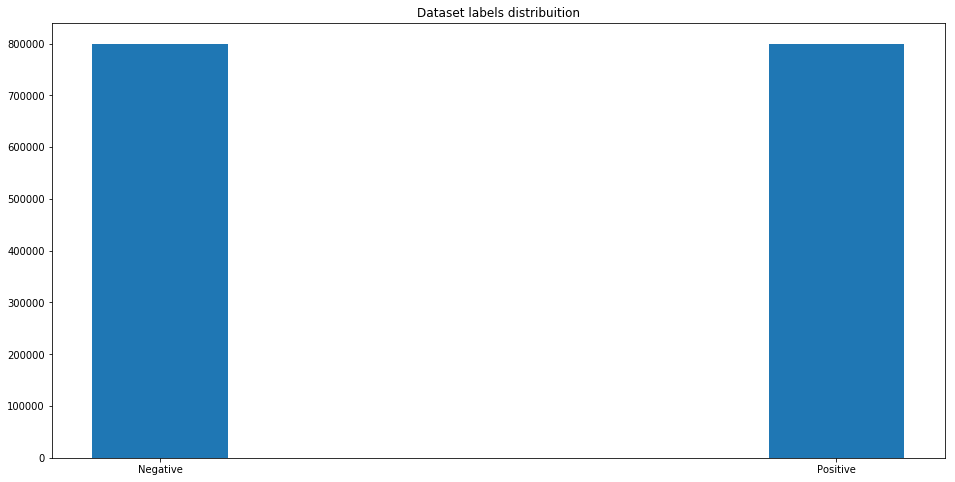

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

target_cnt = Counter(original_training_df['polarity'])

plt.figure(figsize = (16, 8))
plt.xticks([0,4], ['Negative', 'Positive'])
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

The dataset contains thes same size of rows for Negative and Positive tweets, here we will keep a balanced set of 25000 positive and 25000 negative tweets taken randomly

In [6]:
num_rows_from_each_class = 25000
some_negative = original_training_df[original_training_df['polarity'] == 0].sample(num_rows_from_each_class)
some_positive = original_training_df[original_training_df['polarity'] == 4].sample(num_rows_from_each_class)

display(original_training_df.polarity.unique())
original_training_df = pd.concat([some_negative, some_positive])

array([0, 4])

## Preprocessing

In [7]:
import re

class Preprocess:
    # Remove person tags e.g. @person some other text
    @staticmethod
    def remove_tags(sentence):
        return re.sub(r'@[A-Za-z0-9]+', ' ', sentence)

    @staticmethod
    def remove_urls(sentence):
        return re.sub('https?://[A-Za-z0-9./]+', ' ', sentence)

    @staticmethod
    def remove_underscores(sentence):
        return re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    
    @staticmethod
    def remove_special_characters(sentence):
        return re.sub(r'\W', ' ', sentence)

    @staticmethod
    def remove_rem_tags(sentence):
        return re.sub(r'^@\s+', ' ', sentence)

    @staticmethod
    def remove_rem_underscores(sentence):
        return re.sub(r'^ _\s+', ' ', sentence)
    
    @staticmethod
    def remove_multiple_spaces(sentence):
        return re.sub(r' +', ' ', sentence)

    @staticmethod
    def remove_trailing_spaces(sentence):
        return sentence.strip()

In [8]:
def preprocess_row(row):
    row = Preprocess.remove_tags(row)
    row = Preprocess.remove_urls(row)
    row = Preprocess.remove_underscores(row)
    row = Preprocess.remove_special_characters(row)
    row = Preprocess.remove_rem_tags(row)
    row = Preprocess.remove_rem_underscores(row)
    row = Preprocess.remove_multiple_spaces(row)
    row = Preprocess.remove_trailing_spaces(row)
    row = row.lower()
    
    return row

In [9]:
df = original_training_df.copy()
df['text_before_preprocess'] = df['text']
df.drop(columns=['date', 'query'], axis = 1, inplace = True)
df['length_before_preprocess'] = df['text_before_preprocess'].str.len()
df.reset_index(drop = True, inplace = True)

In [10]:
df['text']= df['text'].apply(lambda row: preprocess_row(row))
df['length'] = df['text'].str.len()

In [11]:
df.head(10)

,polarity,user,text,text_before_preprocess,length_before_preprocess,length
0,0,katezoe,who i am hates who i ve been reliant k pull yo self together mate love,@JackAllTimeLow who I am hates who I've been - reliant k ? PULL YO'SELF TOGETHER MATE. Love.,94,70
1,0,kenzineill,laying out then a five hour drive home i m ready for nice weather though,Laying out! Then a five hour drive home I'm ready for nice weather though.,75,72
2,0,Paralexis,i should go to bed but i am hungry and i can t sleep when i m hungry,I should go to bed but i am hungry and i can't sleep when I'm hungry.,70,68
3,0,Wonder_Wheel,poor dead josh please leave your messages of condolences there boy rip that s sad,@Flash_Forward Poor dead Josh. http://bit.ly/JKpHn Please leave your messages of condolences there. #boy #rip ||| That's sad.,126,81
4,0,julienoodle,if you re talking about the logo contest i didnt enter 4 it so no,"@Lacey0108 if you're talking about the logo contest, I didnt enter 4 it, so no..",81,65
5,0,JessicaaLintonn,noowaaay without me,@pepsiballin NOOWAAAY ... ... without me ?,43,19
6,0,GoogleMeBabe,mayn this whole thing is frustrating i want to go home,Mayn this whole thing is frustrating...I want to go home!,58,54
7,0,sparcd,that s annoying working from home today,@se1 That's annoying. Working from home today,46,39
8,0,akosijaycee,says done reviewing but still not feeling well,says done reviewing...but still not feeling well... http://plurk.com/p/13vn9x,78,46
9,0,nsyncs,stealing spmeones internet on my ipod no real internet till tomorrow what am i supposed to do all night i wish i had a book to read,Stealing spmeones Internet on my iPod. No real Internet till tomorrow what am I supposed to do all night! I wish I had a book to read,134,131


## Keep only relevant data

We shall drop columns not required for our purposes and keep the rest, namely the Tweet text and the polarity, as the target variable.

In [12]:
corpus = df['text'].values.tolist()
target = df['polarity'].values.tolist()

In [13]:
# Drop duplicate tweets
df = df.drop_duplicates(subset=['user', 'text'], keep = 'first')

In [14]:
df.drop(columns = ['user'], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)

## Train-test split

Split the dataset to a train / dev sets.

In [15]:
import sklearn.model_selection

X_train, X_dev, y_train, y_dev = sklearn.model_selection.train_test_split(
    corpus, 
    target, 
    test_size = 0.25, 
    shuffle = True
)

In [16]:
print('Size of X_train: ', len(X_train))
print('Size of X_dev: ', len(X_dev))
print('Size of y_train: ', len(y_train))
print('Size of y_dev: ', len(y_dev))

Size of X_train:  37500
Size of X_dev:  12500
Size of y_train:  37500
Size of y_dev:  12500


In [17]:
import itertools
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_dev = le.transform(y_dev)

## Creating word embeddings

### TF/IDF vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [19]:
tf_idf_vectorizer = TfidfVectorizer(
        ngram_range = (1, 2),
        max_features = 15000,
        sublinear_tf = True,
        lowercase = True,
        stop_words = stopwords.words('english')
    )

vectorized_x_train = tf_idf_vectorizer.fit_transform(X_train)
vectorized_x_dev = tf_idf_vectorizer.transform(X_dev)

In [20]:
# Preview of TF/IDF embeddings.
feature_names = tf_idf_vectorizer.get_feature_names()
corpus_index = [n for n in X_train]
pd.DataFrame(vectorized_x_train.todense(), index = corpus_index, columns = feature_names).head(5)

,00,00 morning,00 pm,000,000 contacts,000 followers,00am,00pm,01,02,...,ðµð,ðµñ,ð¹,ð¼ð,ð¼ð¾ð,ð½ð,ð½ðµ,ð¾,ð¾ð,ð¾ñ
oh yeah mornin karate today x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
poor guy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i wish today was better oh well next weekend will be awesome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is work opened the 8 just had some white rice and curry shrimp 4 breakfast lol nd yup just as predicted the bf woke me up lastnite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i m so nervous for you are brave my thoughts are with you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Dictionary with TF/IDF score of each word
tf_idf_vectorizer_words = dict(zip(tf_idf_vectorizer.get_feature_names(), tf_idf_vectorizer.idf_))

In [30]:
tf_idf_vectorizer_words['test']

7.357735608373982

### Pre-trained Word2Vec model on Twitter data

Using GenSim to load 200-dim pre-trained Twitter word embeddings.

In [22]:
import gensim.downloader as GensimDownloader
from gensim.models import Word2Vec, KeyedVectors

In [23]:
w2v_model = GensimDownloader.load("glove-twitter-200")

In [31]:
import numpy as np

'''
    Computes the mean vector of all Word2Vec embeddings of a given sentence.
    
    :param sentence: Input sentence.
    :param w2v_model: Word2Vec binary model.
    
    :returns: mean vector (Numpy 200-dim row vector).
'''
def word2vec_embed_sentence(sentence:str, w2v_model:Word2Vec):
    import numpy as np
    from nltk.corpus import stopwords
    
    # Split and remove stopwords (too slow).
    # words = [word for word in sentence.split() if word not in stopwords.words('english')]
    
    words = sentence.split()
    
    # Create a mxn matrix to store a single sentence's word embeddings.
    word_embeddings = np.zeros((len(words), 200))
    
    # Create an m-vector to hold TF/IDF scores of each word.
    tfidf_embeddings = np.zeros((len(words), 1))
    
    for i, word in enumerate(words):
        if word in w2v_model.vocab and word in tf_idf_vectorizer_words:
            word_embeddings[i, :] = w2v_model[word]
            tfidf_embeddings[i, 0] = tf_idf_vectorizer_words[word]
            
    # Compute the centroid of the sentence.
    t_centroid = np.sum(word_embeddings * tfidf_embeddings, axis = 0) / np.sum(tfidf_embeddings)
    
    return t_centroid

'''
    Computes Word2Vec embeddings for an entire input set.
    
    :param X: Input set.
    :param w2v_model: Word2Vec binary model.
    
    :returns: Matrix of Word2Vec embeddings (len(X)x200 matrix).
'''
def word2vec_embed_X(X:np.ndarray, w2v_model:Word2Vec):
    import numpy as np
    
    # Create a len(X)x200 matrix to store the entire set word embeddings.
    sentence_embeddings = np.zeros((len(X), 200))
    
    for i, x in enumerate(X):
        sentence_embeddings[i, :] = word2vec_embed_sentence(x, w2v_model)
    
    return sentence_embeddings

In [32]:
# Create Word2Vec vectorized data sets.
w2v_vectorized_x_train = word2vec_embed_X(X_train, w2v_model)
w2v_vectorized_x_dev = word2vec_embed_X(X_dev, w2v_model)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [33]:
# Impute missing or inappropriate numerical values.
from sklearn.impute import SimpleImputer

w2v_vectorized_x_train = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_train)
w2v_vectorized_x_dev = SimpleImputer(strategy = "mean").fit_transform(w2v_vectorized_x_dev)

In [34]:
# Check for missing or inappropriate numerical values.
import numpy as np

print("np.inf=", np.where(np.isnan(w2v_vectorized_x_train)))
print("is.inf=", np.where(np.isinf(w2v_vectorized_x_train)))
print("np.max=", np.max(abs(w2v_vectorized_x_train)))

print("np.inf=", np.where(np.isnan(w2v_vectorized_x_dev)))
print("is.inf=", np.where(np.isinf(w2v_vectorized_x_dev)))
print("np.max=", np.max(abs(w2v_vectorized_x_dev)))

np.inf= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= 6.2743000984191895
np.inf= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= 6.2743000984191895


# Classifiers

In [35]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def get_mismatched_tweets(x, y_true, y_pred):
    if( not (len(x) == len(y_true) == len(y_pred))):
        raise 'Invalid Sizes'
    return pd.DataFrame.from_dict([{'text': x[i], 'actual': y_true[i], 'predicted': y_pred[i]} for i in range(len(y_true)) if y_true[i]!=y_pred[i]])

'''
    Performs classification using the 'clf' estimator parameter.
    
    If the model has been previously fitted and saved, it is loaded and used for classification.
    Otherwise, the estimator is fitted.
    
    :param file_path: The file path of the saved model. Also used for saving the model, if not previsouly saved.
    :param clf: The estimator to use. 
    :param X_train: Features training set.
    :param X_dev: Features dev set.
    :param y_train: Target training set.
    :param y_dev: Target dev set.
    :param retrain: Indicates whether we desire that our model is retrained (True), 
                    regardless of the presence of a previously saved model.
'''
def classify(file_path:str, clf:BaseEstimator, X_train:np.ndarray, X_dev:np.ndarray, y_train:np.ndarray, y_dev:np.ndarray, retrain:bool = False):
    clf_saved = load_model(file_path)
    
    # Model has not been saved
    if (clf_saved == None) or (retrain == True):
        clf.fit(X_train, y_train)
        
        # Save fitted model
        save_model(file_path, clf)
        
        # Apply model for prediction on training set
        y_train_pred = clf.predict(X_train)
        
        score = f1_score(y_train, y_train_pred, average = 'micro')
        print("train f1-score:", score)

        # Apply model for prediction on training set
        y_test_pred = clf.predict(X_dev)
        
        score = f1_score(y_dev, y_test_pred, average = 'micro')
        print("test f1-score:", score)
        print()
        print("test data confusion matrix")
        
        y_pred = pd.Series(y_test_pred, name = 'Predicted')
        y_true = pd.Series(y_dev, name = 'True')
        display(pd.crosstab(y_true, y_pred))
        
        print("test data metrics")
        print(classification_report(y_true, y_pred))
        
        return y_test_pred
    # Use saved model
    else:
        # Apply model for prediction on training set
        y_train_pred = clf_saved.predict(X_train)
        
        score = f1_score(y_train, y_train_pred, average = 'micro')
        print("train f1-score:", score)

        # Apply model for prediction on training set
        y_test_pred = clf_saved.predict(X_dev)
        
        score = f1_score(y_dev, y_test_pred, average = 'micro')
        print("test f1-score:", score)
        print()
        print("test data confusion matrix")
        
        y_pred = pd.Series(y_test_pred, name = 'Predicted')
        y_true = pd.Series(y_dev, name = 'True')
        display(pd.crosstab(y_true, y_pred))
        
        print("test data metrics")
        print(classification_report(y_true, y_pred))
        return y_test_pred

We will try to get a soft estimate of how each of the classifiers perform without paramter tuning

## Dummy Classifier

We use this as the base classifier, the Dummy classifier does not have any logic on classification and its expected to classify all as a specific class. the f1 score is expected to be around 50%

In [27]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy = 'most_frequent')

classify("models/frozen/dummy_tfidf.model", clf, vectorized_x_train, vectorized_x_dev, y_train, y_dev, retrain = True)

train f1-score: 0.5044533333333333
test f1-score: 0.48664

test data confusion matrix


Predicted,0
True,
0,6083
1,6417


test data metrics
              precision    recall  f1-score   support

           0       0.49      1.00      0.65      6083
           1       0.00      0.00      0.00      6417

    accuracy                           0.49     12500
   macro avg       0.24      0.50      0.33     12500
weighted avg       0.24      0.49      0.32     12500



/home/manos/.conda/envs/ta_assignment2_1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0, 0, 0, ..., 0, 0, 0])

## Naive-Bayes Classifier

#### With TF/IDF vectors

In [28]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

classify("models/frozen/multinomial_NB_tfidf.model", clf, vectorized_x_train, vectorized_x_dev, y_train, y_dev, retrain = True)

train f1-score: 0.82704
test f1-score: 0.7348

test data confusion matrix


Predicted,0,1
True,,
0,4634,1449
1,1866,4551


test data metrics
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      6083
           1       0.76      0.71      0.73      6417

    accuracy                           0.73     12500
   macro avg       0.74      0.74      0.73     12500
weighted avg       0.74      0.73      0.73     12500



array([1, 1, 1, ..., 1, 0, 0])

#### With Word2Vec vectors
Since this is a model based on a multinomial Gaussian distribution, we cannot use the Word2Vec vectors because they contain negative values.

## Logistic Regression

#### With TF/IDF vectors

In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver = "liblinear")

classify("models/frozen/logistic_regression_tfidf.model", clf, vectorized_x_train, vectorized_x_dev, y_train, y_dev, retrain = False)

train f1-score: 0.8278666666666666
test f1-score: 0.74816

test data confusion matrix


Predicted,0,1
True,,
0,4517,1566
1,1582,4835


test data metrics
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      6083
           1       0.76      0.75      0.75      6417

    accuracy                           0.75     12500
   macro avg       0.75      0.75      0.75     12500
weighted avg       0.75      0.75      0.75     12500



array([1, 1, 1, ..., 1, 0, 0])

#### With Word2Vec vectors

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="liblinear")

classify("models/frozen/logistic_regression_w2v.model", clf, w2v_vectorized_x_train, w2v_vectorized_x_dev, y_train, y_dev, retrain = False)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.1 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


train f1-score: 0.73776
test f1-score: 0.7309599999999999

test data confusion matrix


Predicted,0,1
True,,
0,4576,1657
1,1706,4561


test data metrics
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      6233
           1       0.73      0.73      0.73      6267

    accuracy                           0.73     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.73      0.73      0.73     12500



array([1, 0, 0, ..., 1, 1, 0])

## SVM classifier

#### Without dimensionality reduction

#### With TF/IDF vectors

In [37]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

classify("models/frozen/SVM_tfidf.model", clf, vectorized_x_train, vectorized_x_dev, y_train, y_dev, retrain = False)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.1 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


train f1-score: 0.84824
test f1-score: 0.74496

test data confusion matrix


Predicted,0,1
True,,
0,4565,1668
1,1520,4747


test data metrics
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      6233
           1       0.74      0.76      0.75      6267

    accuracy                           0.74     12500
   macro avg       0.75      0.74      0.74     12500
weighted avg       0.75      0.74      0.74     12500



array([1, 0, 0, ..., 1, 1, 0])

#### With Word2Vec vectors

In [38]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

classify("models/frozen/SVM_w2v.model", clf, w2v_vectorized_x_train, w2v_vectorized_x_dev, y_train, y_dev, retrain = True)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.1 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


train f1-score: 0.7371466666666666
test f1-score: 0.73128

test data confusion matrix


Predicted,0,1
True,,
0,4554,1679
1,1680,4587


test data metrics
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      6233
           1       0.73      0.73      0.73      6267

    accuracy                           0.73     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.73      0.73      0.73     12500



array([1, 0, 1, ..., 1, 1, 0])

#### With dimensionality reduction (SVD)

#### With TF/IDF vectors

In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 100, random_state = 4321)

In [34]:
# Create TF/IDF vectorized data sets.
vectorized_x_train_svd = svd.fit_transform(vectorized_x_train)
vectorized_x_dev_svd = svd.transform(vectorized_x_dev)

In [35]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

classify("models/frozen/SVM_tfidf_svd.model", clf, vectorized_x_train_svd, vectorized_x_dev_svd, y_train, y_dev, retrain = False)

train f1-score: 0.6926933333333334
test f1-score: 0.68264

test data confusion matrix


Predicted,0,1
True,,
0,4114,1969
1,1998,4419


test data metrics
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      6083
           1       0.69      0.69      0.69      6417

    accuracy                           0.68     12500
   macro avg       0.68      0.68      0.68     12500
weighted avg       0.68      0.68      0.68     12500



array([0, 1, 1, ..., 1, 1, 0])

#### With Word2Vec vectors

In [41]:
# Create TF/IDF vectorized data sets.
w2v_vectorized_x_train_svd = svd.fit_transform(w2v_vectorized_x_train)
w2v_vectorized_x_dev_svd = svd.transform(w2v_vectorized_x_dev)

In [42]:
from sklearn import svm

clf = svm.SVC(kernel = 'linear')

classify("models/frozen/SVM_w2v_svd.model", clf, w2v_vectorized_x_train_svd, w2v_vectorized_x_dev_svd, y_train, y_dev, retrain = True)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.1 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


train f1-score: 0.7319733333333334
test f1-score: 0.7272

test data confusion matrix


Predicted,0,1
True,,
0,4555,1678
1,1732,4535


test data metrics
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      6233
           1       0.73      0.72      0.73      6267

    accuracy                           0.73     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.73      0.73      0.73     12500



array([1, 0, 1, ..., 1, 1, 0])

## KNN classifier

#### With TF/IDF vectors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)

classify("models/frozen/KNN_tfidf.model", clf, vectorized_x_train, vectorized_x_dev, y_train, y_dev, retrain = False)

train f1-score: 0.7300266666666667
test f1-score: 0.57752

test data confusion matrix


Predicted,0,1
True,,
0,2901,3182
1,2099,4318


test data metrics
              precision    recall  f1-score   support

           0       0.58      0.48      0.52      6083
           1       0.58      0.67      0.62      6417

    accuracy                           0.58     12500
   macro avg       0.58      0.57      0.57     12500
weighted avg       0.58      0.58      0.57     12500



array([0, 1, 1, ..., 0, 1, 0])

#### With Word2Vec vectors

In [44]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)

classify("models/frozen/KNN_w2v.model", clf, w2v_vectorized_x_train, w2v_vectorized_x_dev, y_train, y_dev, retrain = False)

/home/sp/anaconda3/envs/msc-ds-core-ta-homework-2/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.21.1 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


train f1-score: 0.7642666666666666
test f1-score: 0.64688

test data confusion matrix


Predicted,0,1
True,,
0,3930,2303
1,2111,4156


test data metrics
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      6233
           1       0.64      0.66      0.65      6267

    accuracy                           0.65     12500
   macro avg       0.65      0.65      0.65     12500
weighted avg       0.65      0.65      0.65     12500



array([1, 0, 0, ..., 0, 1, 0])

## Parameter Optimization

In [61]:
import os
from pprint import pprint
from time import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold

X = corpus
y = target

### Grid Search for NBayes Classifier

In [62]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__max_features': [None, 5000, 10000, 15000, 25000],
    'vect__ngram_range': [(1, 1), (1, 2), (2, 3)],
    'clf__alpha': (0.001, 0.00001, 0.0000001)
}

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()

cv = StratifiedKFold(n_splits=5, random_state = 3143113413, shuffle = True)

grid_search = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = os.cpu_count() - 1, verbose = 1, error_score = 'raise')
grid_search.fit(X, y)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
bestNaiveBayesEstimator = grid_search.best_estimator_

save_model("models/frozen/naive_bayes_best.model", bestNaiveBayesEstimator)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.001, 1e-05, 1e-07),
 'vect__max_features': [None, 5000, 10000, 15000, 25000],
 'vect__ngram_range': [(1, 1), (1, 2), (2, 3)]}
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   13.9s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 225 out of 225 | elapsed:  1.3min finished


done in 81.656s

Best score: 0.763
Best parameters set:
	clf__alpha: 0.001
	vect__max_features: 10000
	vect__ngram_range: (1, 2)


We have already used grid_search to find best number of features for training tf-idf vectorizer which is 25000 features
and the ngram range which is (1,2) using N-Bayes classifier. Given that we want to find best parameter set for the below classifiers and since a feature set of more than 5000 is highly unpropable to give us a better score. We chose to not grid-search on the tfidf vectorizer and keep the same best parameters that we found above. And instead take more time to optimize each classifier's configuration parameters.

### Grid Search for Logistic Regression

In [63]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

parameters = {
    'vect__max_features': [10000],
    'vect__ngram_range': [(1, 2)],
    'clf__solver': ['liblinear'],
    'clf__C': [1, 10, 100, 1000]
}

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()

cv = StratifiedKFold(n_splits = 5, random_state = 3143113413, shuffle = True)

grid_search = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = os.cpu_count() - 1, verbose = 1, error_score = 'raise')
grid_search.fit(X, y)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

bestLogisticRgressionEstimator = grid_search.best_estimator_

save_model("models/frozen/logistic_regression_best.model", bestLogisticRgressionEstimator)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': [1, 10, 100, 1000],
 'clf__solver': ['liblinear'],
 'vect__max_features': [10000],
 'vect__ngram_range': [(1, 2)]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  20 out of  20 | elapsed:   10.4s finished


done in 12.119s

Best score: 0.779
Best parameters set:
	clf__C: 1
	clf__solver: 'liblinear'
	vect__max_features: 10000
	vect__ngram_range: (1, 2)


### Grid Search for k-NN Classifier

In [64]:
# pipeline = Pipeline([
#             ('vect', TfidfVectorizer()),
#             ('clf', KNeighborsClassifier())
#         ])

# parameters = {
#     'vect__max_features': [10000],
#     'vect__ngram_range': [(1, 2)],
#     'clf__n_neighbors': [5, 7],
#     'clf__weights': ['distance'],
#     'clf__metric': ['euclidean']
# }

# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# pprint(parameters)
# t0 = time()

# cv = StratifiedKFold(n_splits=5, random_state=3143113413, shuffle=True)

# grid_search = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=os.cpu_count() - 1, verbose=1, error_score='raise')
# grid_search.fit(X, y)

# print("done in %0.3fs" % (time() - t0))
# print()

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# bestKNNClassifierEstimator = grid_search.best_estimator_

# save_model("models/frozen/knn_classifier_best.model", bestKNNClassifierEstimator)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__metric': ['euclidean'],
 'clf__n_neighbors': [5, 7],
 'clf__weights': ['distance'],
 'vect__max_features': [10000],
 'vect__ngram_range': [(1, 2)]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   8 out of  10 | elapsed:   29.3s remaining:    7.3s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   29.6s finished


done in 31.000s

Best score: 0.562
Best parameters set:
	clf__metric: 'euclidean'
	clf__n_neighbors: 5
	clf__weights: 'distance'
	vect__max_features: 10000
	vect__ngram_range: (1, 2)


Parameter tuning for KNN classifier took more than 8 hours. we can't tune it.
We could not tune parameters on SVM because it required much time but we can see thatn kNN with parameter tuning couldn't score better than 
Logistic regression which hold our best score until now.

## Plot Learning Curves

For the best estimators we found above.

In [65]:
import numpy as np
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs,scoring = 'f1', train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()

    plt.fill_between(
        train_sizes, 
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, 
        alpha = 0.1,
        color="b"
    )
    
    plt.fill_between(
        train_sizes, 
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, 
        alpha = 0.1, color = "orange"
    )
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "orange", label = "Cross-validation score")

    plt.legend(loc = "lower right")
    
    return plt

In [66]:
X, y = vectorized_x_train, y_train

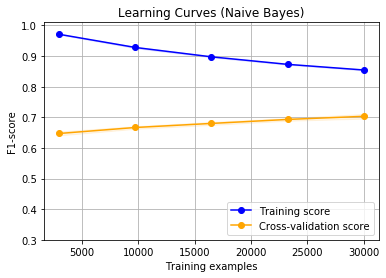

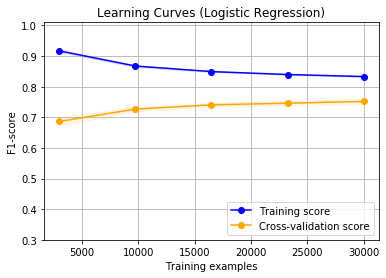

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 123123123)
estimator = clone(bestNaiveBayesEstimator['clf'])
plot_learning_curve(estimator, title, X, y, ylim = (0.3, 1.01), cv = cv, n_jobs = 2)
plt.show()

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
estimator = clone(bestLogisticRgressionEstimator['clf'])
plot_learning_curve(estimator, title, X, y, (0.3, 1.01), cv = cv, n_jobs = 2)
plt.show()

## Pressision Recall curves

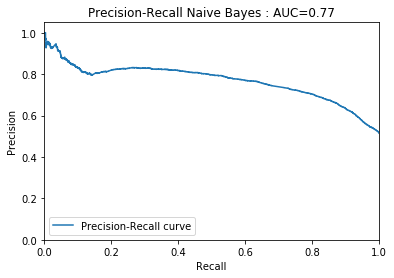

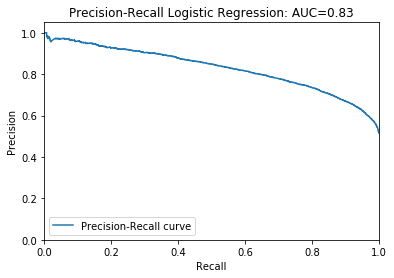

In [68]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import clone

#disable warnings for large float numbers of estimated probabilities
np.seterr(all = 'ignore')
estimators = {
    'Naive Bayes ': clone(bestNaiveBayesEstimator['clf']),
    'Logistic Regression': clone(bestLogisticRgressionEstimator['clf'])
}

for (name,estimator) in estimators.items():
    
    model = estimator
    model.fit(X, y)
    pred = model.predict_proba(vectorized_x_dev)
    precision, recall, thresholds = precision_recall_curve(y_dev, pred[:, 1])
    area = auc(recall, precision)

    plt.plot(recall, precision, label = 'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name, area))
    plt.legend(loc = "lower left")
    plt.show()

# Validation on the test Set

In [69]:
original_test_df = create_dataset(
    'data/testdata.manual.2009.06.14.csv', 
    sys.maxsize
)

In [70]:
display(original_test_df.head(10))
display(original_test_df.size)

,polarity,date,query,user,text
id,,,,,
9,0,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non loan given asses.
14,0,Mon May 11 03:32:48 UTC 2009,obama,kylesellers,"@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil. It's a charade and a slogan, but they want to destroy conservatism"
17,0,Mon May 11 05:06:22 UTC 2009,nike,vincentx24x,"dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x"
19,0,Mon May 11 05:20:28 UTC 2009,lebron,luv8242,I was talking to this guy last night and he was telling me that he is a die hard Spurs fan. He also told me that he hates LeBron James.
21,0,Mon May 11 05:21:37 UTC 2009,lebron,ursecretdezire,"@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end."
119,0,Sat May 16 16:19:24 UTC 2009,google,vamsmack,Played with an android google phone. The slide out screen scares me I would break that fucker so fast. Still prefer my iPhone.
120,0,Sat May 16 16:25:41 UTC 2009,aig,schroncd,US planning to resume the military tribunals at Guantanamo Bay... only this time those on trial will be AIG execs and Chrysler debt holders
121,0,Sat May 16 22:42:07 UTC 2009,itchy,MarissaLeeD,omg so bored &amp; my tattoooos are so itchy!! help! aha =)
122,0,Sat May 16 22:42:25 UTC 2009,itchy,robloposky,I'm itchy and miserable!


1795

## Normalize data

Before using the test set to perform classification, we should apply the same preprocessing rules tat we employed in oprder to train the model, so as to establish the a baseline.

In [71]:
df_test = original_test_df.copy()
df_test.drop(columns = ['date', 'query', 'user'], axis = 1, inplace = True)
df_test.reset_index(drop=True, inplace = True)

In [72]:
df_test['text'] = df_test['text'].apply(lambda row: preprocess_row(row))

In [73]:
display(df_test.head())

,polarity,text
0,0,fuck this economy i hate aig and their non loan given asses
1,0,i firmly believe that obama pelosi have zero desire to be civil it s a charade and a slogan but they want to destroy conservatism
2,0,dear nike stop with the flywire that shit is a waste of science and ugly love
3,0,i was talking to this guy last night and he was telling me that he is a die hard spurs fan he also told me that he hates lebron james
4,0,lebron is a beast but i m still cheering 4 the a til the end


In [74]:
X_test = df_test['text'].values.tolist()
y_test = df_test['polarity'].values.tolist()

Text(0.5, 1.0, 'Dataset labels distribuition')

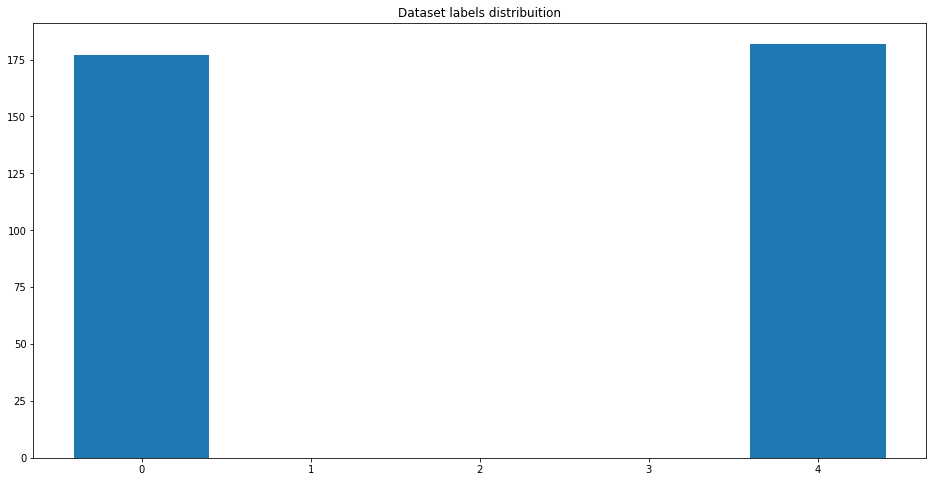

In [75]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

target_cnt = Counter(y_test)

plt.figure(figsize = (16, 8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [76]:
import pandas as pd

y_pred = bestLogisticRgressionEstimator.predict(X_test)
score = f1_score(y_test, y_pred, average = 'micro')
print("test f1-score:", score)
print()

y_true = pd.Series(y_test, name = 'True')
y_pred = pd.Series(y_pred, name = 'Predicted')
display(pd.crosstab(y_true, y_pred))

test f1-score: 0.7715877437325905



Predicted,0,4
True,,
0,122,55
4,27,155


In [77]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       177
           4       0.74      0.85      0.79       182

    accuracy                           0.77       359
   macro avg       0.78      0.77      0.77       359
weighted avg       0.78      0.77      0.77       359



In [78]:
get_mismatched_tweets(X_test, y_true, y_pred)

,actual,predicted,text
0,0,4,dear nike stop with the flywire that shit is a waste of science and ugly love
1,0,4,us planning to resume the military tribunals at guantanamo bay only this time those on trial will be aig execs and chrysler debt holders
2,0,4,no i m not itchy for now maybe later lol
3,0,4,obama administration must stop bonuses to aig ponzi schemers
4,0,4,started to think that citi is in really deep s amp t are they gonna survive the turmoil or are they gonna be the next aig
5,0,4,because the twitter api is slow and most client s aren t good
6,0,4,yahoo answers can be a butt sometimes
7,0,4,rt was just told that nike layoffs started today
8,0,4,can we just go ahead and blow north korea off the map already
9,0,4,insects have infected my spinach plant


---